In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
from pathlib import Path
from finta import TA
import matplotlib.pyplot as plt
import quantstats as qs
import itertools
from IPython.display import clear_output

In [2]:
### Quant framework 3 x 3 x 3

#     Intraday   >>Swing<<    >>Position<<

#     Earnings     Event      >>TA<<

#   >>Delta<<      Theta        Vega

# Project 2 scope is focused on Swing and Position timeframe, while relying on TA
# to determine signals. Option strategies are not used.

### Technical goal:

# Automate creation and testing of new trading algorithms based on our framework

### Plan:

# 1. Pull the data: ohlc + volume ✓
# 2. Integrate Finta with our data ✓
# 3. Determine trading signals for testable indicators (crossovers, etc.)✓
# 4. Test the strategy on data of 2017 - 2019 
# 5. Automate testing of different combinations of strategies
# 6. Train ML algorithms on best performing strategies
# 7. Deploy trained ML algorithms and test performance on 2020-2023 data

In [3]:
sqrt = np.sqrt(252)
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()

# Portfolio vars

share_size = 100
initial_capital = 100000

# Optionable stocks 
optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

In [4]:
optionable_stocks

'FCX GOLD NEM WPM X TMUS VZ ROKU SNAP SPOT T NFLX META DIS DISH ATVI AMZN DHI ETSY GM MGM NKE HD M SBUX TSLA WMT TGT MO KO PEP PG PM CAG BYND ADM APA CCJ CVX DVN MRO HAL MPC SLB OXY VLO MA MARA JPM PYPL MS GDXJ BX COF AXP C BAC AFL AMGN ABBV ABT BMY CAH CVS PFE JNJ MDT MRK MRNA WBA RTX LUV PLUG MMM GE CAT CSX DAL BA AAL AMT WELL ZM SQ AMD AAPL CRM MRVL NVDA ORCL QCOM MSFT MU HPQ INTC '

# 1. Pull the data: ohlc + volume

In [5]:
yf_df = yf.Tickers(optionable_stocks)
df_full =yf_df.history(start = '2017-01-01', end = yesterday)

[*********************100%***********************]  95 of 95 completed


In [6]:
stocks = df_full[['Open', 'Close', 'High', 'Low', 'Volume']]
stocks.dropna(inplace= True, axis= 1)

stock_names = stocks.columns.get_level_values(1).unique().tolist()

stocks.head()

Open                                                         \
                  AAL       AAPL       ABBV        ABT        ADM        AFL   
Date                                                                           
2017-01-03  45.688232  27.014199  47.239336  34.444810  38.090092  29.976890   
2017-01-04  45.060119  27.025865  47.029117  34.828233  38.665325  29.938394   
2017-01-05  44.953811  27.042193  47.584705  34.988725  38.431891  30.062422   
2017-01-06  44.306378  27.242817  47.960092  35.398887  37.531543  30.019648   
2017-01-09  44.460992  27.515755  47.900034  36.370804  37.106362  29.891356   

                                                     ...   Volume           \
              AMD        AMGN        AMT       AMZN  ...      TGT     TMUS   
Date                                                 ...                     
2017-01-03  11.42  121.843240  92.865291  37.896000  ...  3907100  3004100   
2017-01-04  11.45  125.328987  92.586845  37.919498  ...  5316200  5540600   
2017-01-05  11.43  125.848131  92.230097  38.077499  ...  7096300  5427200   
2017-01-06  11.29  131.748269  92.169199  39.118000  ...  5235100  4776100   
2017-01-09  11.37  129.383247  91.795060  39.900002  ...  3814300  3329700   

                                                                               \
                 TSLA      VLO        VZ      WBA     WELL       WMT      WPM   
Date                                                                            
2017-01-03   88849500  4425000  22891700  4942700  2085000  10473200  6033800   
2017-01-04  168202500  7431000  18316100  4125500  2070700   7918000  4067000   
2017-01-05   88675500  6450600  13840600  7401400  2228000   7099200  6673200   
2017-01-06   82918500  3771700  15615000  3949700  1908600   9491100  5268300   
2017-01-09   59692500  5132600  14097200  3293000  1806600   8685200  5213100   

                      
                   X  
Date                  
2017-01-03  15395700  
2017-01-04  21023000  
2017-01-05  15312600  
2017-01-06  11753400  
2017-01-09  15047400  

[5 rows x 445 columns]

# 2. Integrate Finta with our data 

In [7]:
def get_individual_stock(stock, stocks = stocks):
    mask = stocks.columns.get_level_values(1) == stock
    data = stocks.loc[:, mask]
    data.columns = data.columns.droplevel(1)
    return data

## Getting indicators demo
### Once we have the finalized list of indicators, I will combine them into one function

<Axes: xlabel='Date'>

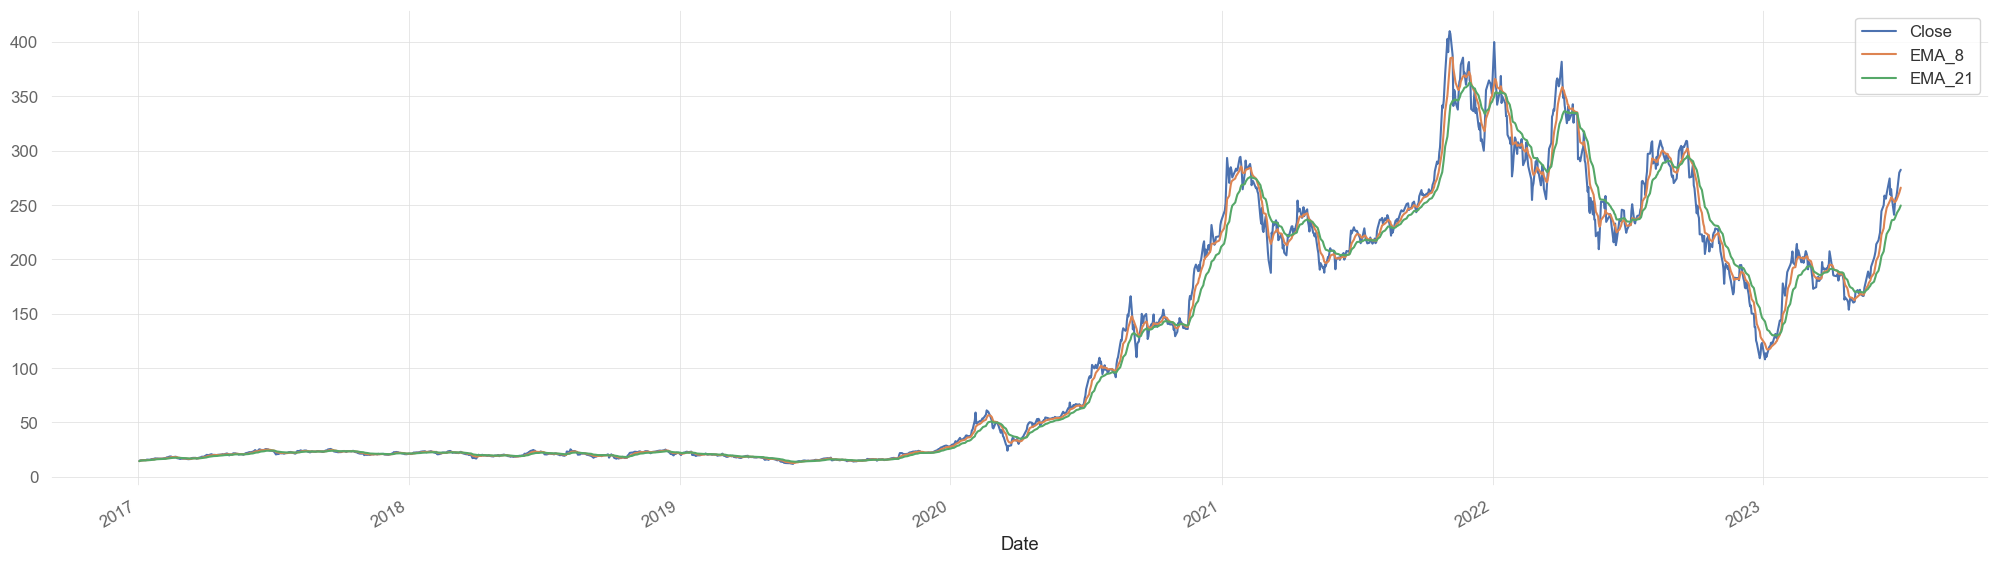

In [8]:
# EMA
short_window = 8
long_window = 21
df = get_individual_stock('TSLA')
df[f'EMA_{short_window}'] = TA.EMA(df, short_window)
df[f'EMA_{long_window}'] = TA.EMA(df, long_window)
df[['Close', 'EMA_8', 'EMA_21']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

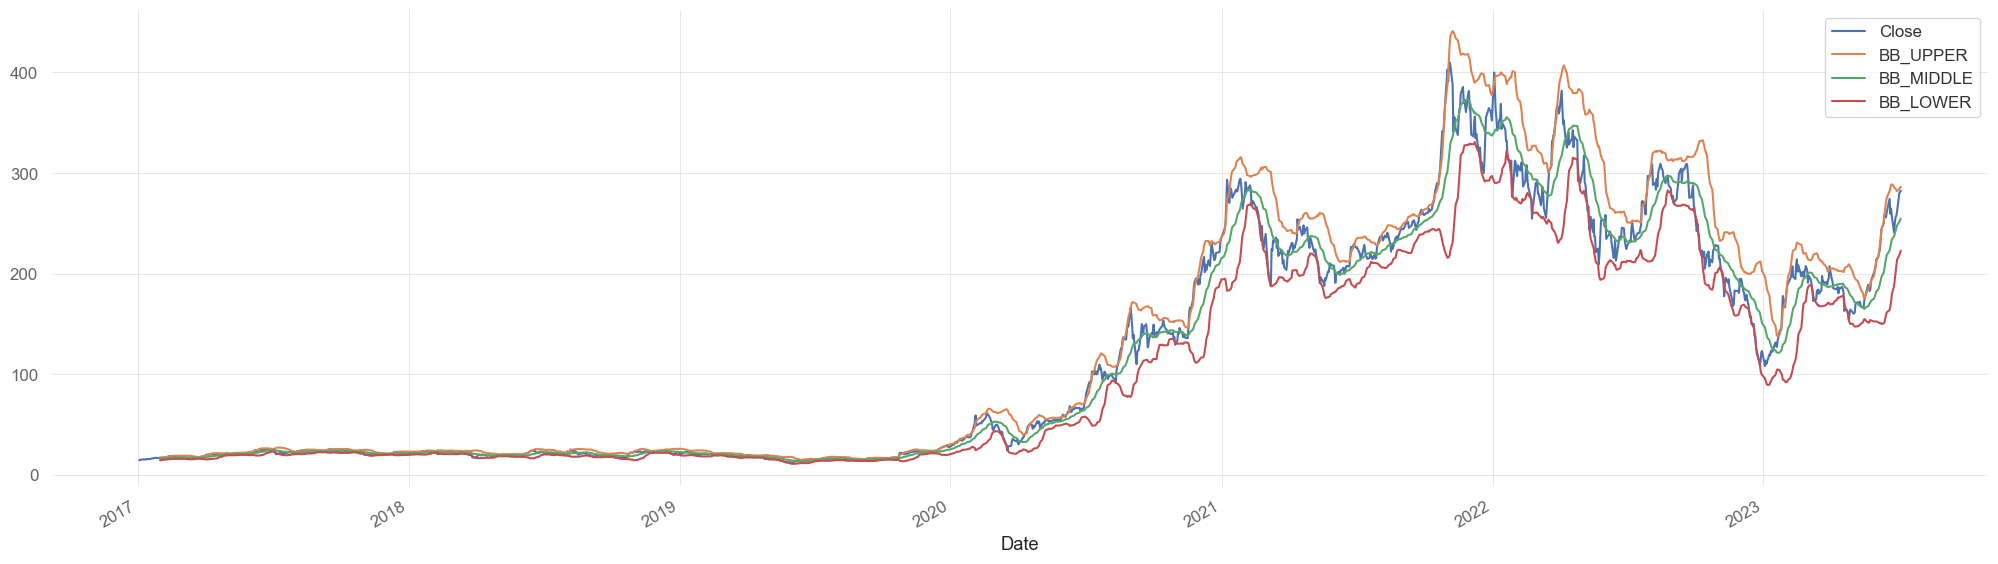

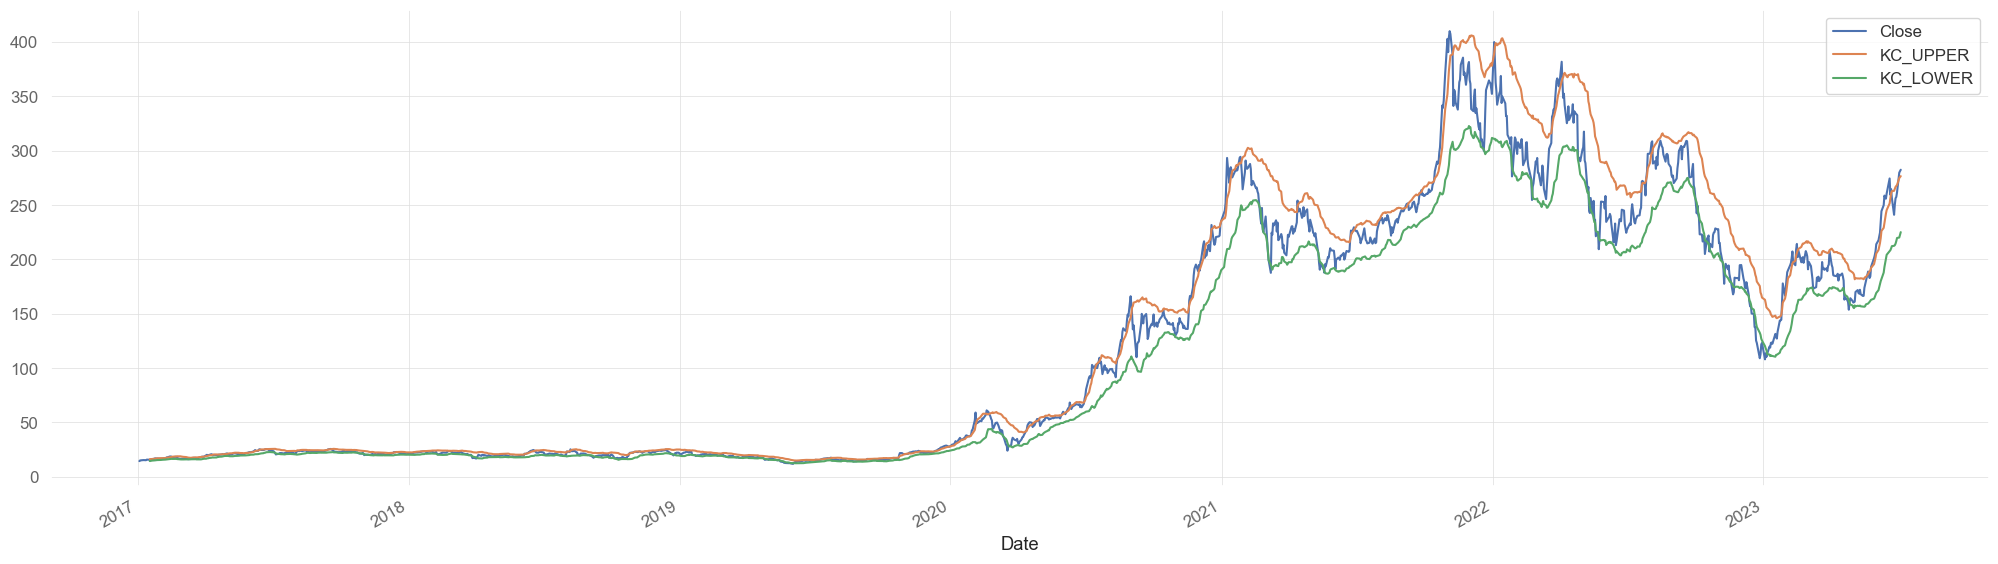

In [9]:
# BBANDS
df = get_individual_stock('TSLA')
df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(df)
df[['Close', 'BB_UPPER','BB_MIDDLE','BB_LOWER']].plot(figsize = (25,7))

# Keltner Channels
df = get_individual_stock('TSLA')
df[['KC_UPPER', 'KC_LOWER']] = TA.KC(df)
df[['Close', 'KC_UPPER', 'KC_LOWER']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

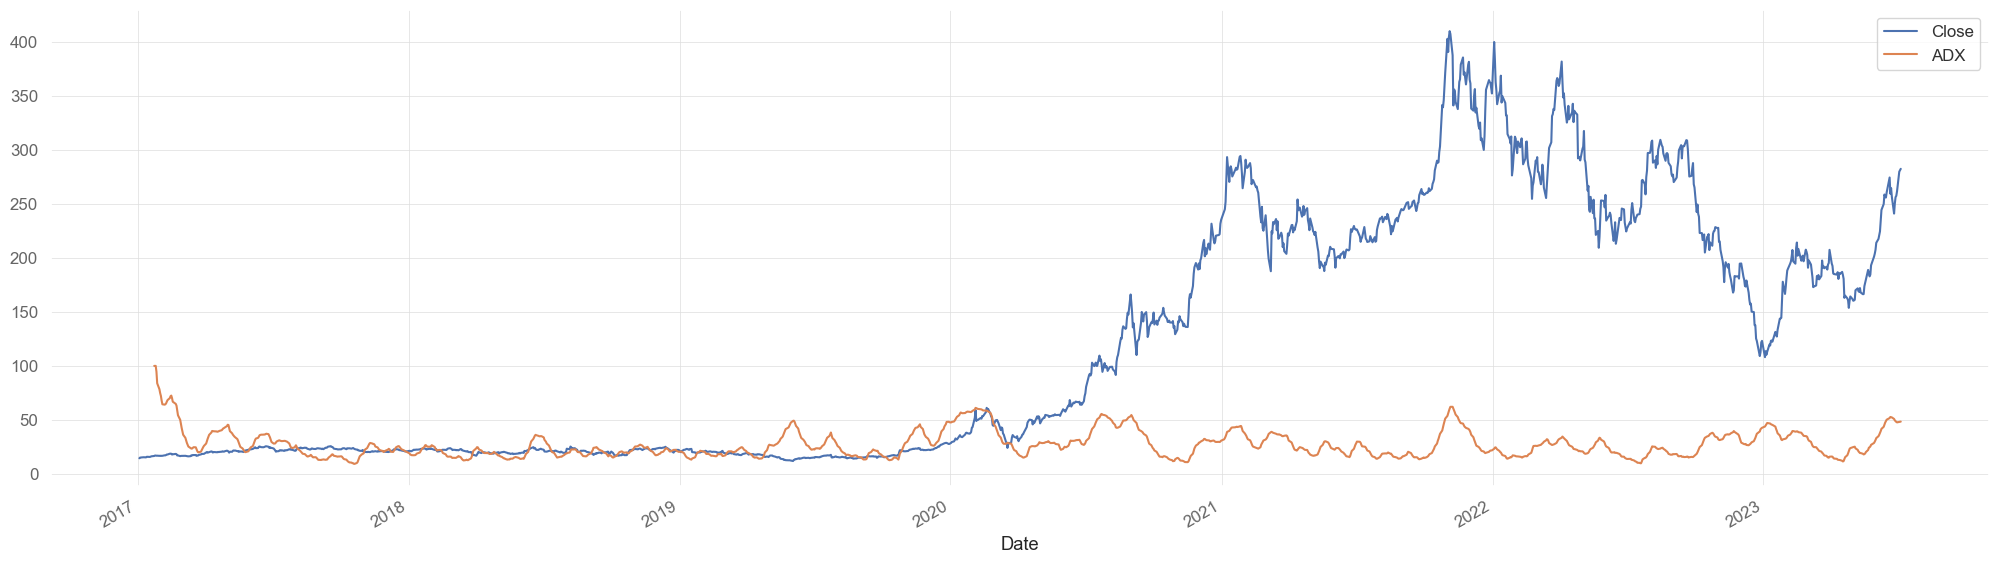

In [10]:
# ADX
df = get_individual_stock('TSLA')
df['ADX'] = TA.ADX(df)
df[['Close','ADX']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

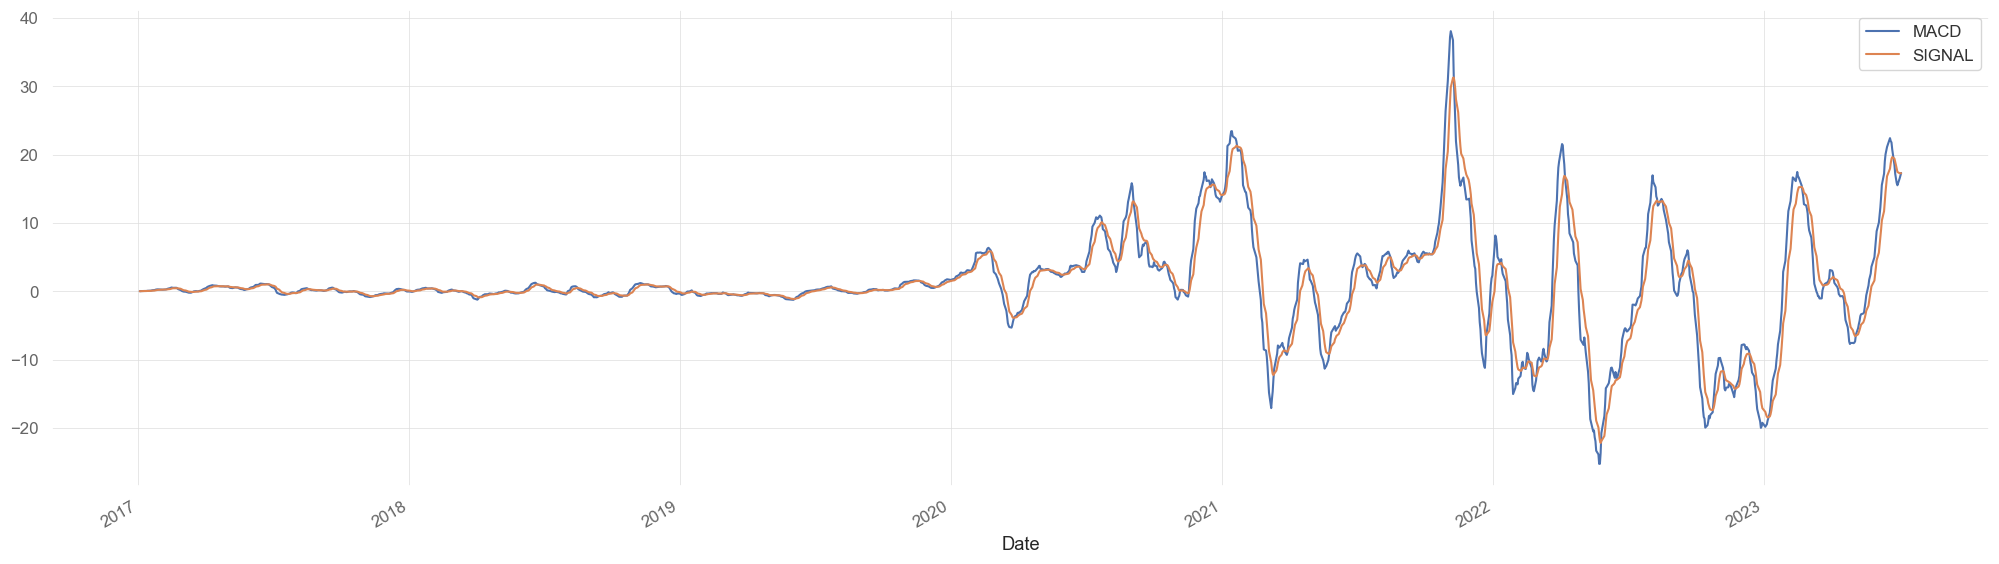

In [11]:
# MACD
df = get_individual_stock('TSLA')
df[['MACD', 'SIGNAL']] = TA.MACD(df)

df[['MACD', 'SIGNAL']].plot(figsize = (25,7))


In [12]:
df = get_individual_stock('TSLA')
df[['TENKAN','KIJUN','senkou_span_a','SENKOU','CHIKOU']] = TA.ICHIMOKU(df)
df

Open       Close        High         Low     Volume  \
Date                                                                    
2017-01-03   14.324000   14.466000   14.688667   14.064000   88849500   
2017-01-04   14.316667   15.132667   15.200000   14.287333  168202500   
2017-01-05   15.094667   15.116667   15.165333   14.796667   88675500   
2017-01-06   15.128667   15.267333   15.354000   15.030000   82918500   
2017-01-09   15.264667   15.418667   15.461333   15.200000   59692500   
...                ...         ...         ...         ...        ...   
2023-06-28  249.699997  256.239990  259.880005  248.889999  159770800   
2023-06-29  258.029999  257.500000  260.739990  253.610001  131283400   
2023-06-30  260.600006  261.769989  264.450012  259.890015  112267600   
2023-07-03  276.489990  279.820007  284.250000  275.109985  119685900   
2023-07-05  278.820007  282.480011  283.850006  277.600006  131530900   

                TENKAN       KIJUN  senkou_span_a      SENKOU     CHIKOU  
Date                                                                      
2017-01-03         NaN         NaN            NaN         NaN  17.946667  
2017-01-04         NaN         NaN            NaN         NaN  17.948668  
2017-01-05         NaN         NaN            NaN         NaN  18.706667  
2017-01-06         NaN         NaN            NaN         NaN  18.732000  
2017-01-09         NaN         NaN            NaN         NaN  18.650667  
...                ...         ...            ...         ...        ...  
2023-06-28  258.844994  227.604996     172.090000  180.079994        NaN  
2023-06-29  258.844994  227.604996     173.932503  180.079994        NaN  
2023-06-30  258.844994  227.604996     175.660004  180.079994        NaN  
2023-07-03  262.474998  232.415001     175.660004  180.079994        NaN  
2023-07-05  262.474998  234.389999     175.660004  180.079994        NaN  

[1636 rows x 10 columns]

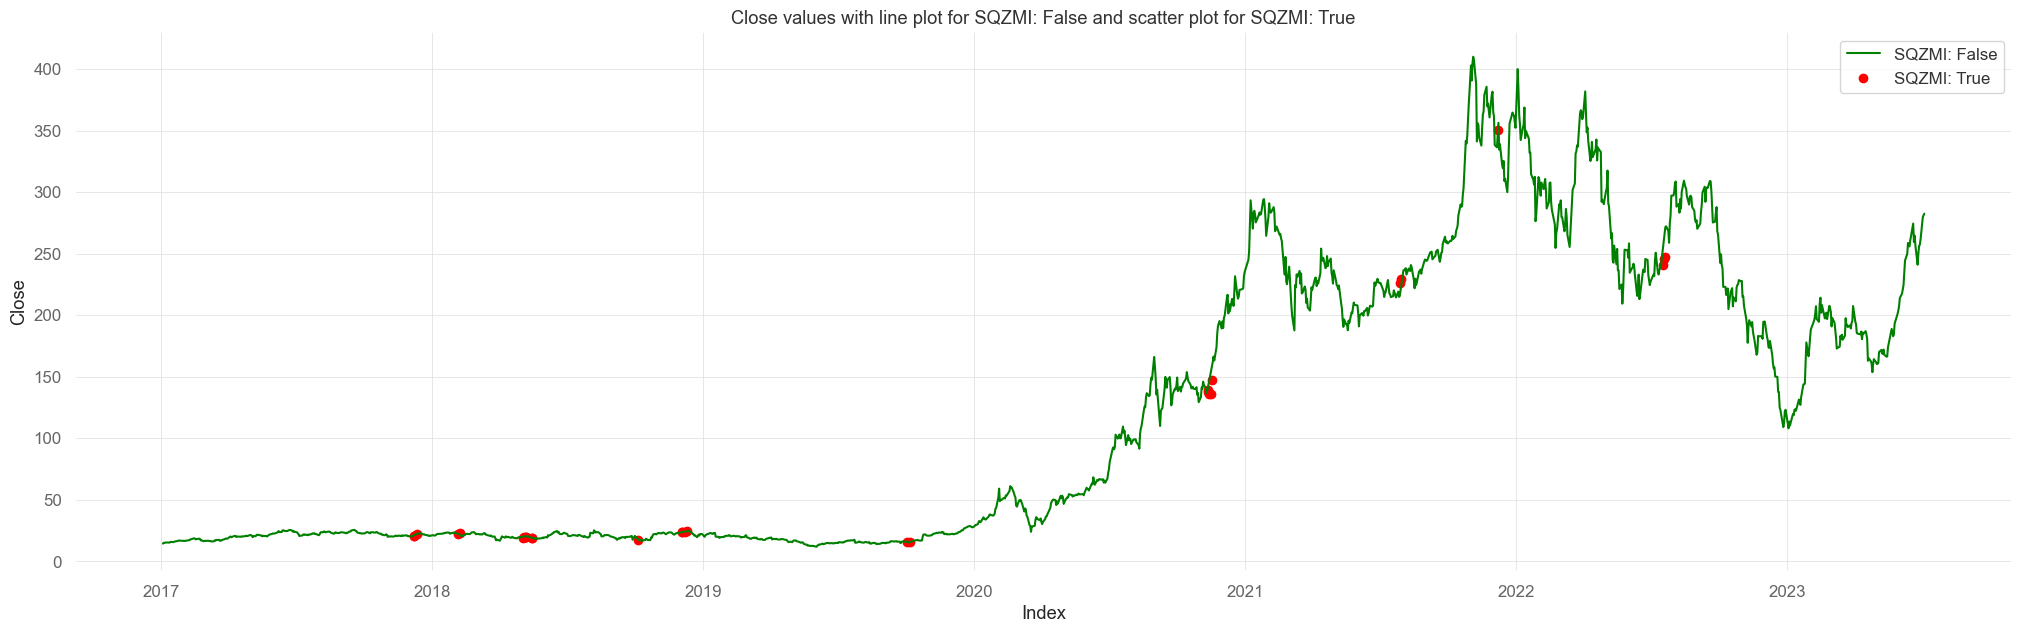

In [13]:
df = get_individual_stock('TSLA')
df['SQZMI'] = TA.SQZMI(df)
# Filter the DataFrame based on SQZMI values
false_df = df[df['SQZMI'] == False]
true_df = df[df['SQZMI'] == True]

# Extract the Close values
false_close_values = false_df['Close']
true_close_values = true_df['Close']

# Set the figure size
plt.figure(figsize=(25, 7))  # Adjust the width and height as desired

# Plot the values
plt.plot(false_close_values, color='green', label='SQZMI: False')
plt.scatter(true_df.index, true_close_values, color='red', label='SQZMI: True')
plt.xlabel('Index')
plt.ylabel('Close')
plt.title("Close values with line plot for SQZMI: False and scatter plot for SQZMI: True")
plt.legend()
plt.show()

In [14]:
TA.RSI(df, period = 21)

Date
2017-01-03           NaN
2017-01-04    100.000000
2017-01-05     97.541975
2017-01-06     98.022569
2017-01-09     98.360619
                 ...    
2023-06-28     64.138556
2023-06-29     64.496555
2023-06-30     65.714445
2023-07-03     70.244876
2023-07-05     70.841079
Name: 21 period RSI, Length: 1636, dtype: float64

# 3. Determine trading signals for testable indicators (crossovers, etc.)

# Iterator Class

In [103]:
# Define a class
class SignalIterator:
    
    def __init__(self, ticker, share_size = 100, initial_cash = 10000, stocks_df = stocks):
        
        self.ticker = ticker
        self.stocks_df = stocks_df
        self.share_size = share_size
        self.initial_cash = initial_cash
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = stocks.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)

    def indicators(self):
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        
         # EMA
        self.df['EMA_50'] = TA.EMA(self.df, 50)
        
        # BBANDS
        self.df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(self.df, std_multiplier= 3)
        
        # SQZ setup
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(df)
        
        # CHAIKIN
        self.df['CHAIKIN'] = TA.CHAIKIN(self.df)
        
        # MFI
        self.df['MFI'] = TA.MFI(self.df)
   
    def signals(self):
        
        ### BUY SIGNALS ###
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)
        
        # EMA Signal logic
        self.df['EMA50_Signal'] = 0.0
        self.df['EMA50_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == False, 1.0, 0.0)
        
        # ADX Signal logic
        self.df['ADX_Signal'] = 0.0
        self.df['ADX_Signal'] = np.where(self.df['ADX'] > 30, 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0)        
        
        # CHAIKIN Signal logic
        self.df['CHAIKIN_Signal'] = 0.0
        self.df['CHAIKIN_Signal'] = np.where(self.df['CHAIKIN'] > 0, 1.0, 0.0)        
        
        # MFI Signal logic
        self.df['MFI_Signal'] = 0.0
        self.df['MFI_Signal'] = np.where(self.df['MFI'] < 20, 1.0, 0.0)    
        
        ### SELL SIGNALS ###
        
        # BBANDS Sell Signal Logic
        self.df['BB_Sell_Signal'] = 0.0
        self.df['BB_Sell_Signal'] = np.where((self.df['Close'] > self.df['BB_UPPER']), 0.0, 1.0)        
        
        # EMA Sell Signal Logic
        self.df['EMA20_Sell_Signal'] = 0.0
        self.df['EMA20_Sell_Signal'] = np.where((self.df['Close'] < self.df['EMA_50']), 0.0, 1.0)        
        
        # MACD Sell Signal logic
        self.df['MACD_Sell_Signal'] = 0.0
        self.df['MACD_Sell_Signal'] = np.where(self.df['MACD'] < self.df['SIGNAL'], 0.0, 1.0)
        
        # ADX Signal logic
        self.df['ADX_Sell_Signal'] = 0.0
        self.df['ADX_Sell_Signal'] = np.where(self.df['ADX'] < 30, 0.0, 1.0)
        
    def result(self):
        
        # Define eval df columns
        columns = ['Buy Signals', 'Sell Signals', 'Annualized Return', 'Cumulative Return', 'Annual Volatility', 'Sharpe Ratio']
        eval_df = pd.DataFrame( columns= columns)
        # Define the signal column names
        buy_signal_columns = ['EMA20_Signal','EMA50_Signal','SQZ_Signal','ADX_Signal','MACD_Signal','CHAIKIN_Signal','MFI_Signal']
        sell_signal_columns = ['BB_Sell_Signal', 'EMA20_Sell_Signal', 'MACD_Sell_Signal','ADX_Sell_Signal']
        # Generate all combinations of signal columns
        for r_buy in range(1, len(buy_signal_columns) + 1):
            combinations_buy = list(itertools.combinations(buy_signal_columns, r_buy))

            # Generate all combinations of sell signal columns
            for r_sell in range(1, len(sell_signal_columns) + 1):
                combinations_sell = list(itertools.combinations(sell_signal_columns, r_sell))

                # Iterate over each combination of buy and sell signals
                for combo_buy in combinations_buy:
                    selected_buy_columns = list(combo_buy)

                    for combo_sell in combinations_sell:
                        selected_sell_columns = list(combo_sell)

                        # Check if all buy signal columns are 1
                        buy_signal = (self.df[selected_buy_columns] == 1).all(axis=1)

                        # Check if all sell signal columns are 0
                        sell_signal = (self.df[selected_sell_columns] == 0).all(axis=1)

                        # Generate the main signal based on buy and sell signals
                        self.df['Main_Signal'] = buy_signal.astype(int) * sell_signal.astype(int)

                        # Entry/Exit logic
                        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()

                        # Performance Metrics
                        self.df["Position"] = self.share_size * self.df['Main_Signal']
                        self.df["Entry/Exit Position"] = self.df["Position"].diff()
                        self.df["Portfolio Holdings"] = self.df["Position"] * self.df['Close']
                        self.df["Portfolio Cash"] = self.initial_cash - (self.df['Close'] * self.df['Entry/Exit Position']).cumsum()
                        self.df["Portfolio Total"] = self.df["Portfolio Cash"] + self.df["Portfolio Holdings"]
                        self.df["Portfolio Daily Returns"] = self.df["Portfolio Total"].pct_change()
                        self.df["Portfolio Cumulative Returns"] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
                        self.df['Buy And Hold Return'] = (1 + self.df["Close"].pct_change()).cumprod()

                        # Create a df with performance summary for each combination

                        # append evaluation metrics to a df as a new row
                        ann_ret =  self.df['Portfolio Daily Returns'].mean() * 252
                        cum_ret = self.df['Portfolio Cumulative Returns'][-1]
                        ann_volat = self.df['Portfolio Daily Returns'].std() * sqrt
                        sharpe = ann_ret / ann_volat
                        buy_and_hold = self.df['Buy And Hold Return'][-1]
                        new_row = {'Buy Signals' : f'{selected_buy_columns}',
                                   'Sell Signals' : f'{selected_sell_columns}',
                                   'Annualized Return' : ann_ret,
                                   'Cumulative Return' : cum_ret,
                                   'Annual Volatility' : ann_volat,
                                   'Sharpe Ratio' : sharpe,
                                   'Buy and Hold': buy_and_hold,
                                   'Ticker': self.ticker}
                        eval_df = eval_df.append(new_row, ignore_index=True)

        self.filtered_df = eval_df[eval_df['Cumulative Return'] > 1].sort_values('Cumulative Return', ascending = False)
        self.filtered_df['Beat Buy and Hold?'] = np.where(self.filtered_df['Cumulative Return'] > self.filtered_df['Buy and Hold'], True, False)        
        return self.filtered_df 

    def plot_top_strategy(self):
        top_5_strategies = self.filtered_df.head(5)

        # Iterate over each row in the top 5 strategies
        for index, row in top_5_strategies.iterrows():
            # Create a new figure for each strategy
            plt.figure(figsize=(25, 10))

            # Get the strategy name
            ticker = row['Ticker']
            selected_buy_columns = eval(row['Buy Signals'])
            selected_sell_columns = eval(row['Sell Signals'])

            # Check if all buy signal columns are 1
            buy_signal = (self.df[selected_buy_columns] == 1).all(axis=1)

            # Check if all sell signal columns are 0
            sell_signal = (self.df[selected_sell_columns] == 0).all(axis=1)

            # Generate the main signal based on buy and sell signals
            self.df['Main_Signal'] = buy_signal.astype(int) * sell_signal.astype(int)

            # Entry/Exit logic
            self.df['Entry/Exit'] = self.df['Main_Signal'].diff()

            # Performance Metrics
            self.df["Position"] = self.share_size * self.df['Main_Signal']
            self.df["Entry/Exit Position"] = self.df["Position"].diff()
            self.df["Portfolio Holdings"] = self.df["Position"] * self.df['Close']
            self.df["Portfolio Cash"] = self.initial_cash - (self.df['Close'] * self.df['Entry/Exit Position']).cumsum()
            self.df["Portfolio Total"] = self.df["Portfolio Cash"] + self.df["Portfolio Holdings"]
            self.df["Portfolio Daily Returns"] = self.df["Portfolio Total"].pct_change()
            self.df["Portfolio Cumulative Returns"] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
            self.df['Buy And Hold Return'] = (1 + self.df["Close"].pct_change()).cumprod()

            # Get the entry/exit signal
            entry_exit = self.df['Entry/Exit']

            portfolio_cumulative_returns = self.df["Portfolio Cumulative Returns"]
            # Plot the portfolio cumulative returns
            plt.plot(portfolio_cumulative_returns, label=f'{ticker} : {selected_buy_columns} & {selected_sell_columns}')

            # Plot the entry/exit points with markers
            plt.plot(entry_exit[entry_exit == 1].index, portfolio_cumulative_returns[entry_exit == 1], 'gv', markersize=15)  # Green markers for entry
            plt.plot(entry_exit[entry_exit == -1].index, portfolio_cumulative_returns[entry_exit == -1], 'r^', markersize=15)  # Red markers for exit

            # Set the plot title and labels
            plt.title("Strategy - Portfolio Cumulative Returns")
            plt.xlabel("Time")
            plt.ylabel("Cumulative Returns")
            plt.legend()

            # Show the plot for the current strategy
            plt.show()


In [104]:
# Class that tests the model on our list of stocks

class Tester:
    
    def __init__(self, stock_list = stock_names):
        self.stock_list = stock_list
        self.backtest_on_stocks()
        self.top_return()
        self.top_sharpe()
        self.beat_bnh()
        
    def backtest_on_stocks(self):
        self.combined = pd.DataFrame()
        for index, stock in enumerate(self.stock_list):
            self.iterator = SignalIterator(stock)
            result = self.iterator.result()
            self.combined = pd.concat([self.combined, result], axis=0)
            clear_output(wait=True)
            print(f'{stock} analysis complete ({index+1}/{len(self.stock_list)})')
    
    def top_return(self):
        return self.combined.sort_values('Cumulative Return', ascending= False).head(50)
    
    def top_sharpe(self):
        return self.combined.sort_values('Sharpe Ratio', ascending= False).head(50)
    
    def beat_bnh(self):
        return self.combined[self.combined['Beat Buy and Hold?'] == True].sort_values('Cumulative Return', ascending= False).head(50)
    def plot_top(self):
        self.iterator.plot_top_strategy()

NVDA analysis complete (2/2)


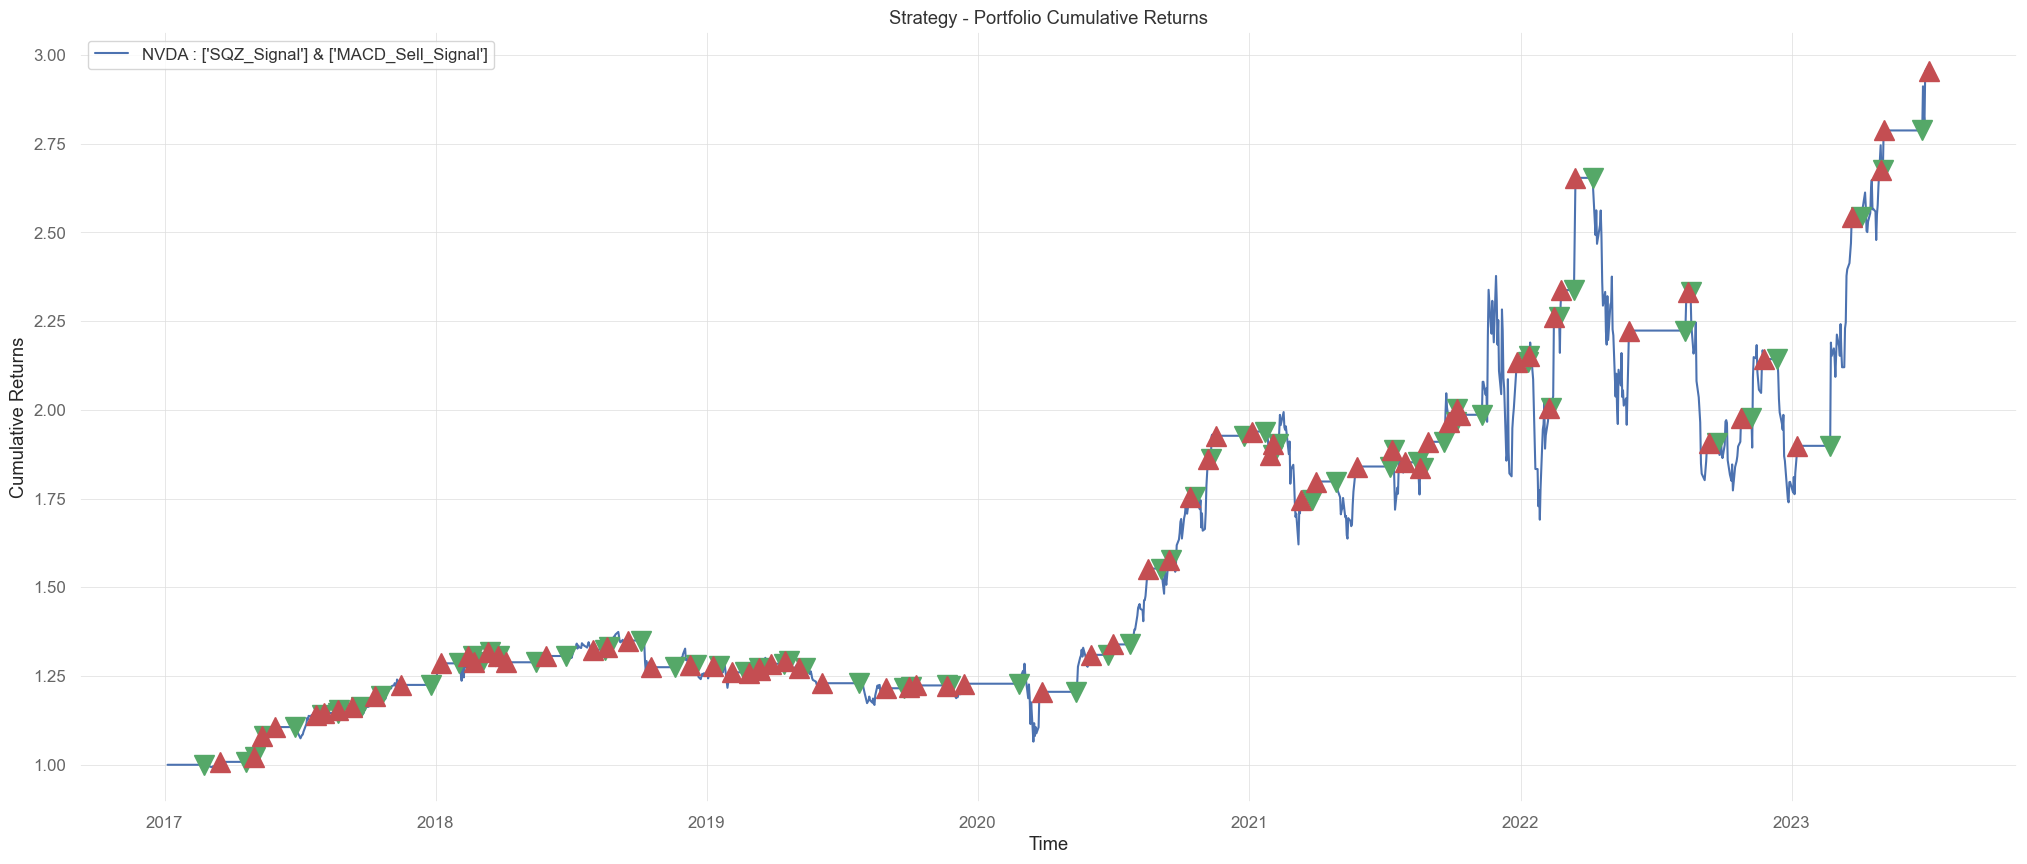

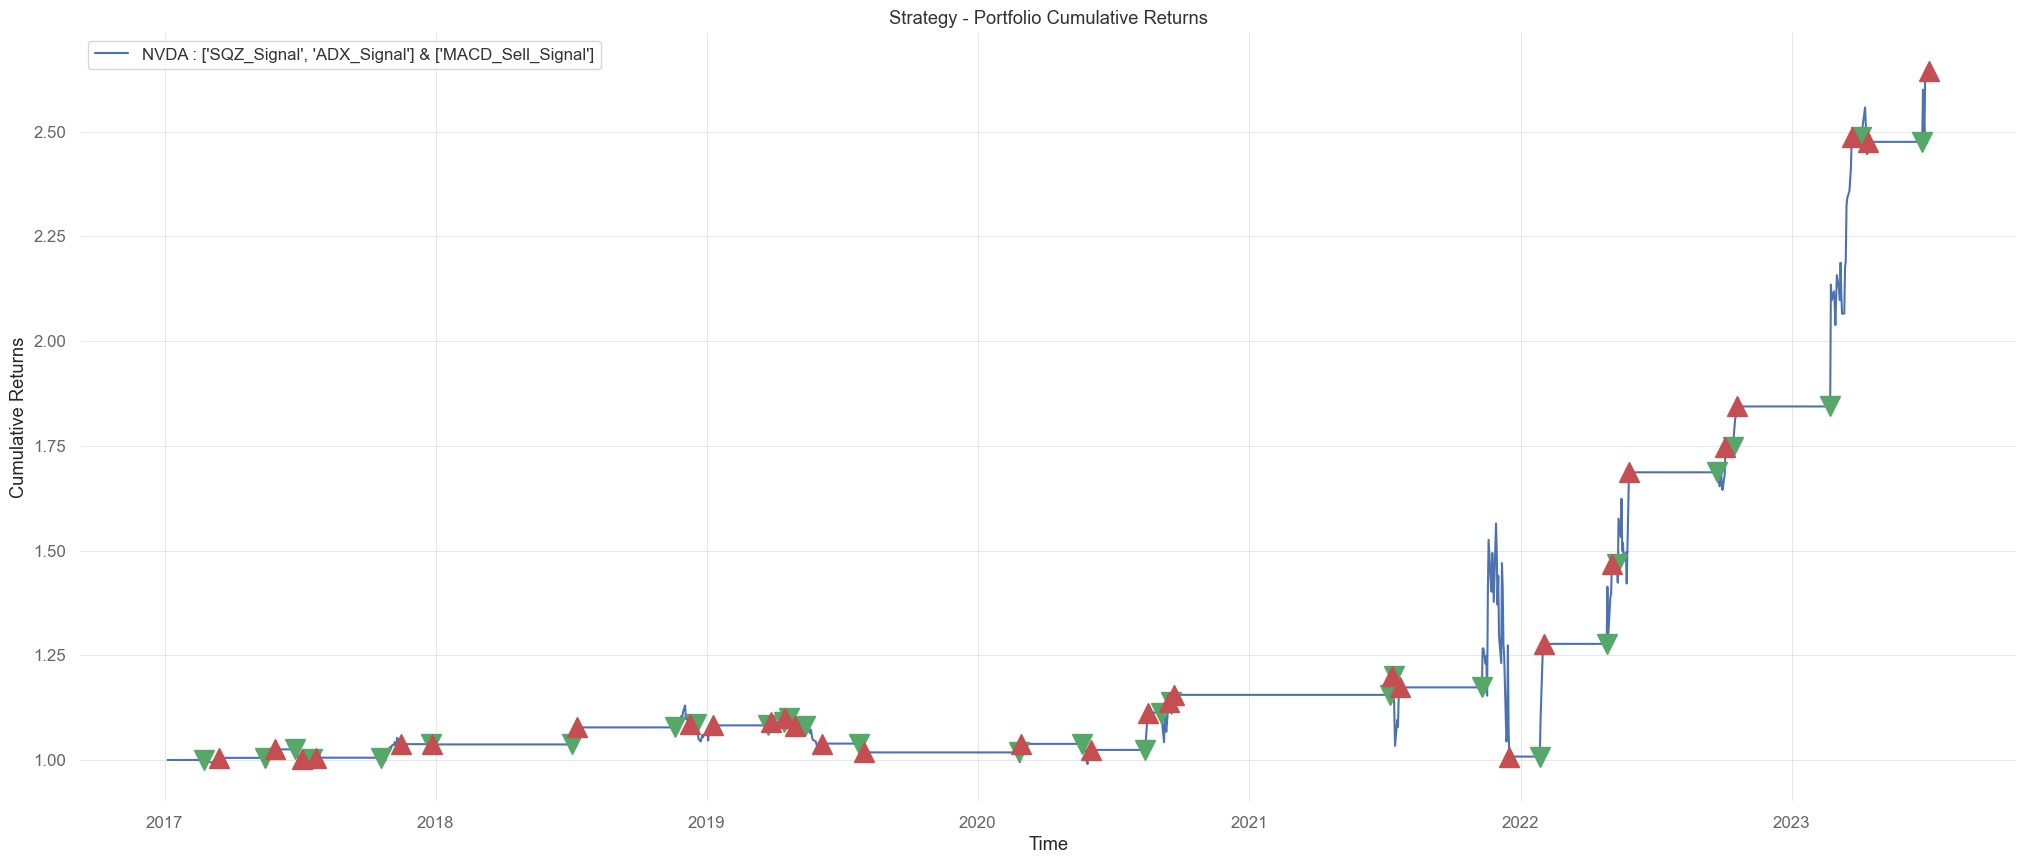

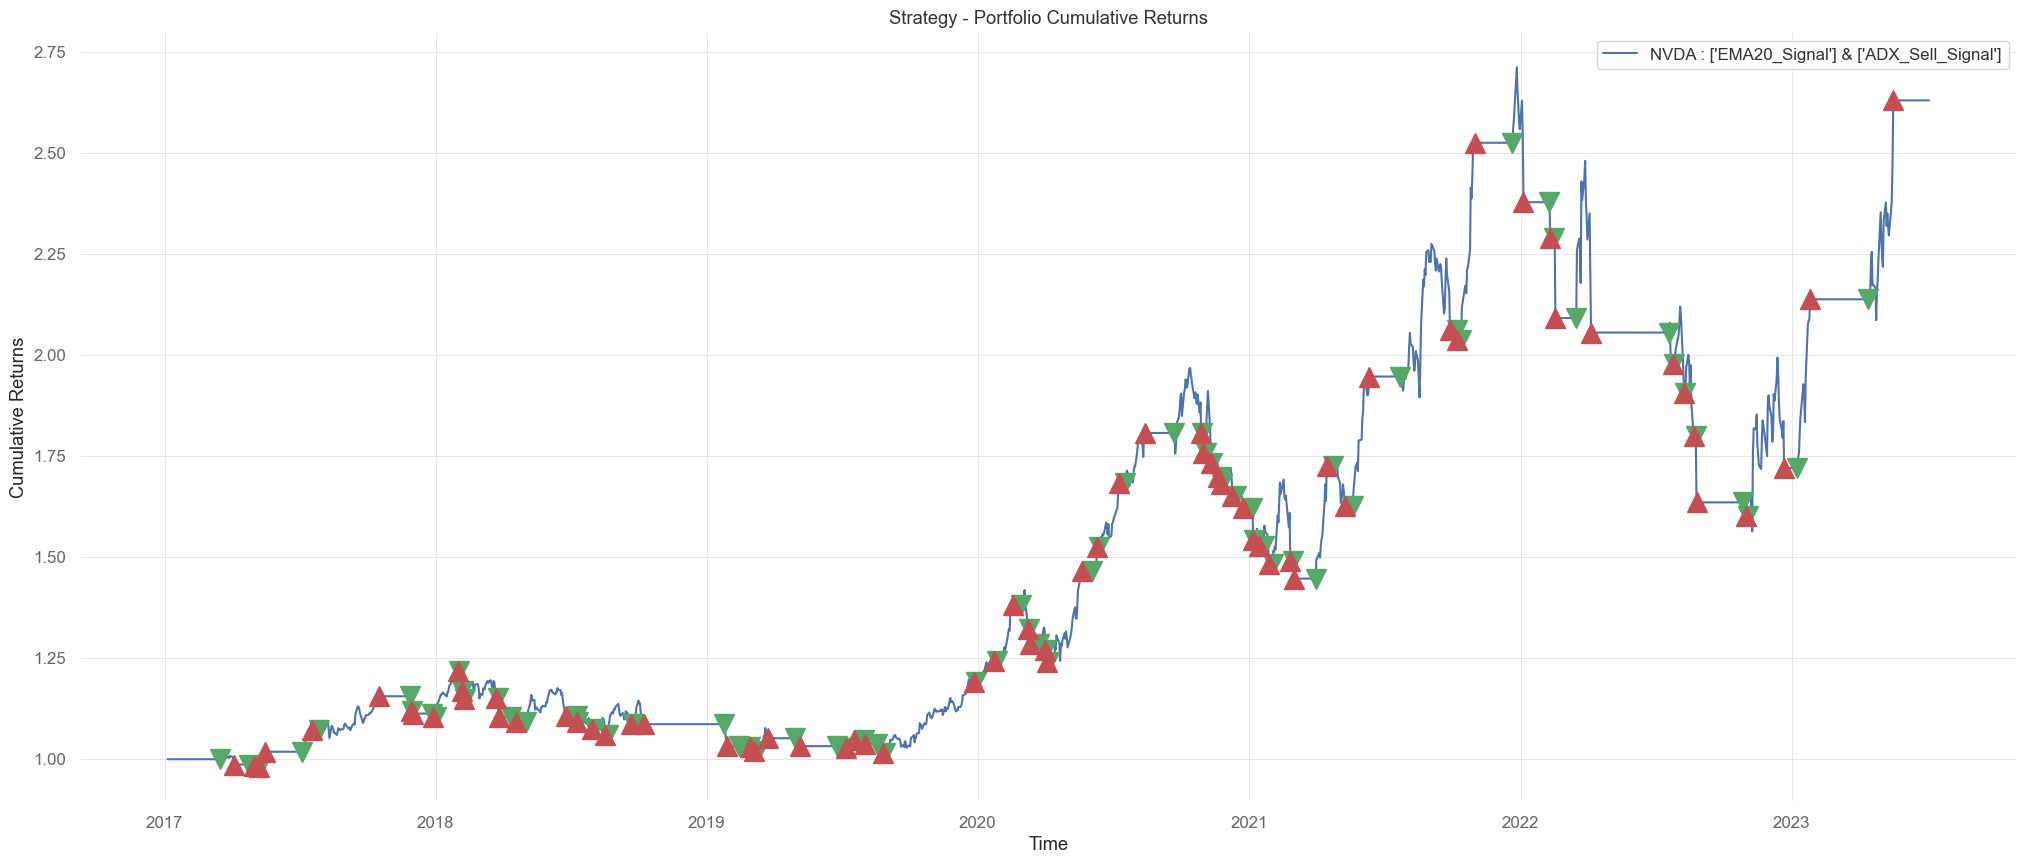

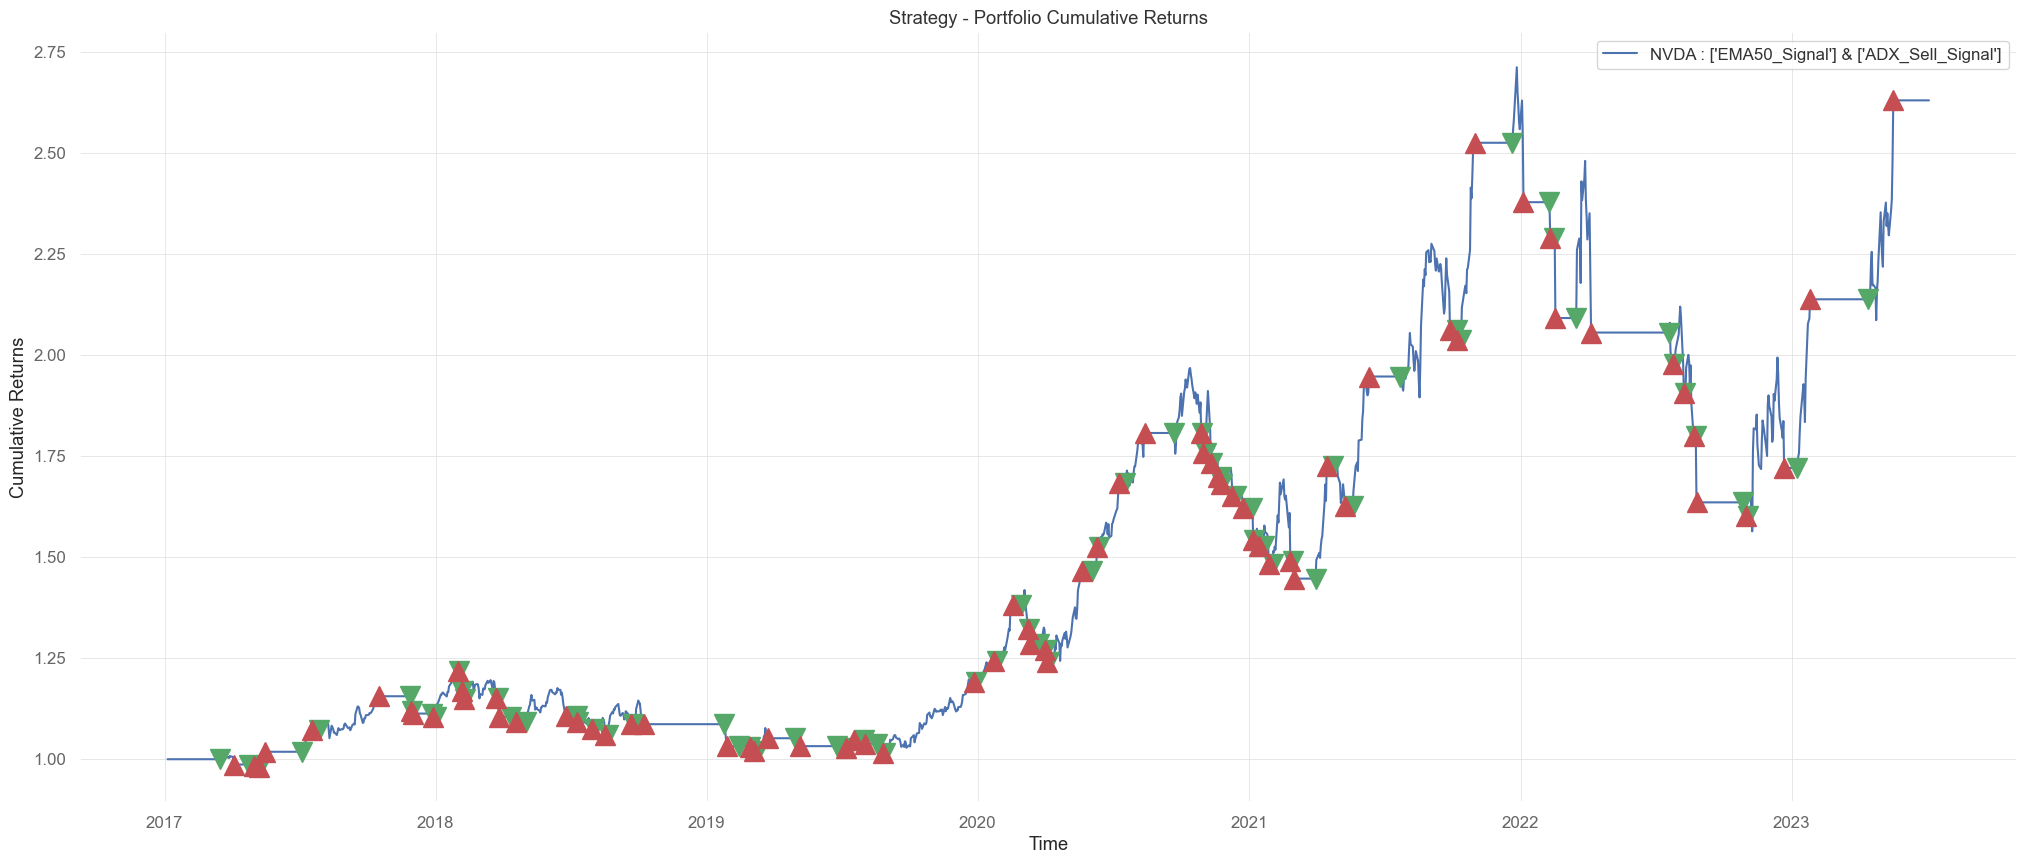

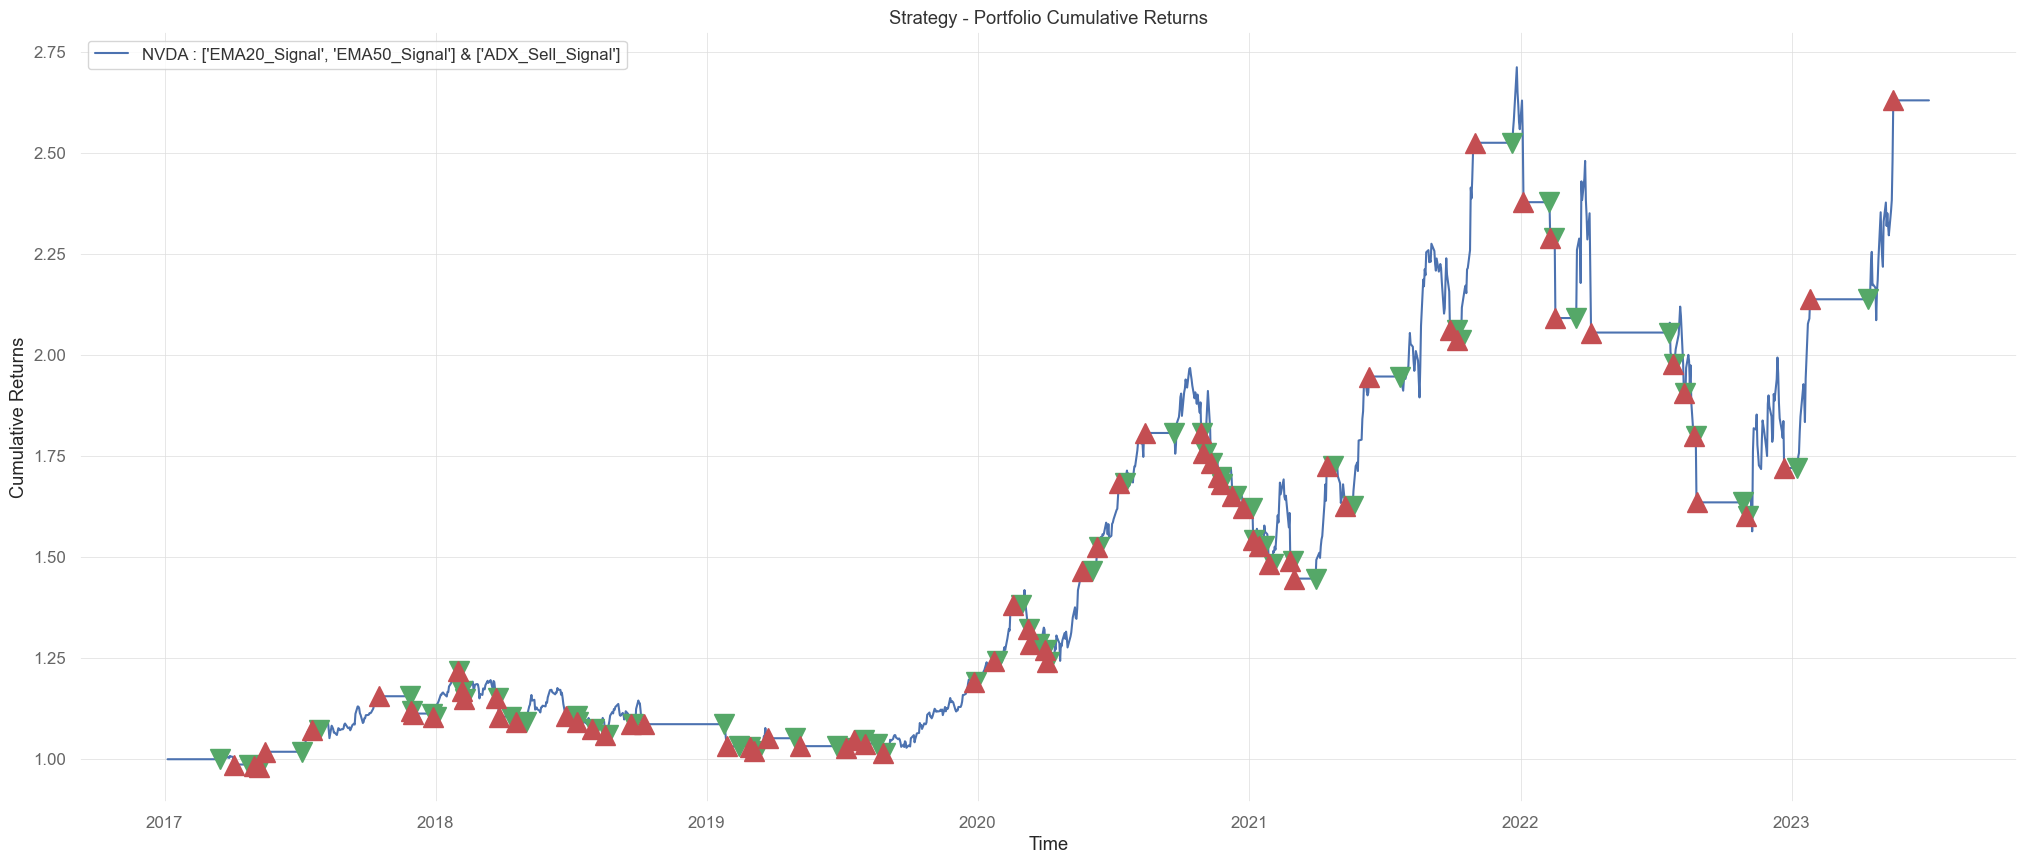

In [105]:
Tester(['AAL', 'NVDA']).plot_top()